# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import SGD
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import scipy
from torchinfo import summary
import pandas as pd
import os
import seaborn as sns

# Import raw data

In [3]:
#Defining function to check if directory exists, if not it generates it
def check_and_make_dir(dir):
    if not os.path.isdir(dir):os.mkdir(dir)
#Base directory 
base_dir = '/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/'
#File containing surface temperature map
raw_ST_data = np.loadtxt(base_dir+'Data/bt-4500k/training_data_ST2D.csv', delimiter=',')
#Path to store model
model_save_path = base_dir+'Model_Storage/GP_ST/'
check_and_make_dir(model_save_path)
#Path to store plots
plot_save_path = base_dir+'Plots/GP_ST/'
check_and_make_dir(plot_save_path)

#Last 51 columns are the temperature/pressure values, 
#First 5 are the input values (H2 pressure in bar, CO2 pressure in bar, LoD in hours, Obliquity in deg, H2+Co2 pressure) but we remove the last one since it's not adding info.
raw_inputs = raw_ST_data[:, :4] #has shape 46 x 72 = 3,312
raw_outputs = raw_ST_data[:, 5:]

#Storing useful quantitites
N = raw_inputs.shape[0] #Number of data points
D = raw_inputs.shape[1] #Number of features
O = raw_outputs.shape[1] #Number of outputs

## HYPER-PARAMETERS ##
#Defining partition of data used for 1. training and 2. testing
data_partition = [0.8, 0.2]

#Definine sub-partitiion for splitting NN dataset
sub_data_partitions = [0.7, 0.1, 0.2]

#Defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_threads = 1
torch.set_num_threads(num_threads)
print(f"Using {device} device with {num_threads} threads")
torch.set_default_device(device)

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4
rng = torch.Generator(device=device)
rng.manual_seed(partition_seed)

# Variable to show plots or not 
show_plot = False

#Number of nearest neighbors to choose
N_neigbors = 500

#Optimizer learning rate
learning_rate = 1e-5

#Batch size 
batch_size = 64

#Number of epochs 
n_epochs = 10

#Define storage for losses
train_losses = []
eval_losses = []

#Mode for optimization
run_mode = 'use'

Using cpu device with 1 threads


# Plotting of the surface temperature map

In [ ]:
for raw_input, raw_output in zip(raw_inputs,raw_outputs):
    
    fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    
    hm = sns.heatmap(raw_output.reshape((46, 72)), ax=ax)
    cbar = hm.collections[0].colorbar
    cbar.set_label('Temperature (K)')

    # Fix longitude ticks
    ax.set_xticks(np.linspace(0, 72, 5))
    ax.set_xticklabels(np.linspace(-180, 180, 5).astype(int))

    # Fix latitude ticks
    ax.set_yticks(np.linspace(0, 46, 5))
    ax.set_yticklabels(np.linspace(-90, 90, 5).astype(int))

    ax.set_xlabel('Longitude (degrees)')
    ax.set_ylabel('Latitude (degrees)')
    plt.suptitle(rf'H$_2$ : {raw_input[0]} bar, CO$_2$ : {raw_input[1]} bar, LoD : {raw_input[2]:.0f} days, Obliquity : {raw_input[3]} deg')
    plt.show()

# Fitting data with an Ensemble Conditional GP

## First step : partition data into a training set, and a testing set

In [4]:
## Retrieving indices of data partitions
train_idx, test_idx = torch.utils.data.random_split(range(N), data_partition, generator=rng)
## Generate the data partitions
### Training
train_inputs = raw_inputs[train_idx]
train_outputs = raw_outputs[train_idx]

### Testing
test_inputs = raw_inputs[test_idx]
test_outputs = raw_outputs[test_idx]

## Second step : Building Sai's Conditional GP function

In [5]:
def Sai_CGP(obs_features, obs_labels, query_features):
    """
    Conditional Gaussian Process
    Inputs: 
        obs_features : ndarray (D, N)
            D-dimensional features of the N observation data points.
        obs_labels : ndarray (K, N)
            K-dimensional labels of the N observation data points.
        query_features : ndarray (D, 1)
            D-dimensional features of the query data point.
    Outputs:
        query_labels : ndarray (K, 1)
            K-dimensional labels of the query data point.

    """
    # Defining relevant means
    mean_obs_labels = np.mean(obs_labels, axis=1, keepdims=True)
    mean_obs_features = np.mean(obs_features, axis=1, keepdims=True)
    
    # Defining relevant covariance matrices
    ## Between feature and label of observation data
    Cyx = (obs_labels @ obs_features.T) / (obs_features.shape[0] - 1)
    ## Between label and feature of observation data
    Cxy = (obs_features @ obs_labels.T) / (obs_features.shape[0] - 1)
    ## Between feature and feature of observation data
    Cxx = (obs_features @ obs_features.T) / (obs_features.shape[0] - 1)
    ## Between label and label of observation data
    Cyy = (obs_labels @ obs_labels.T) / (obs_features.shape[0] - 1)
    ## Adding regularizer to avoid singularities
    Cxx += 1e-8 * np.eye(Cxx.shape[0]) 

    query_mean_labels = mean_obs_labels + (Cyx @ scipy.linalg.inv(Cxx) @ (query_features - mean_obs_features))

    query_cov_labels = Cyy - Cyx @ scipy.linalg.inv(Cxx) @ Cxy

    return query_mean_labels, query_cov_labels

## Third step : Going through test set (query points), find observations in proximity, and use them to get guess labels for query point

In [ ]:
#Initialize array to store residuals
res = np.zeros(test_outputs.shape, dtype=float)

for query_idx, (test_input, test_output) in enumerate(zip(test_inputs, test_outputs)):

    #Calculate proximity of query point to observations
    distances = np.sqrt( (test_input[0] - train_inputs[:,0])**2 + (test_input[1] - train_inputs[:,1])**2 + (test_input[2] - train_inputs[:,2])**2 + (test_input[3] - train_inputs[:,3])**2 )

    #Choose the N closest points
    N_closest_idx = np.argsort(distances)[:N_neigbors]
    prox_train_inputs = train_inputs[N_closest_idx, :]
    prox_train_outputs = train_outputs[N_closest_idx, :]
    
    #Find the query labels from nearest neigbours
    mean_test_output, cov_test_output = Sai_CGP(prox_train_inputs.T, prox_train_outputs.T, test_input.reshape((1, 4)).T)
    model_test_output = mean_test_output[:,0] 
    model_test_output_err = np.sqrt(np.diag(cov_test_output))
    res[query_idx, :] = model_test_output - test_output

    #Diagnostic plot
    if show_plot:

        plt.figure(figsize=(8, 6))
        plt.imshow(cov_test_output, cmap='coolwarm', origin='lower')
        plt.colorbar(label='Covariance')
        plt.title('Joint Covariance Matrix')
        plt.xlabel('Output index')
        plt.ylabel('Output index')
        plt.show()

        #Convert shape
        plot_test_output = test_output.reshape((46, 72))
        plot_model_test_output = mean_test_output.reshape((46, 72))
        plot_res = res[query_idx, :].reshape((46, 72))
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), sharex=True, layout='constrained')        
        # Compute global vmin/vmax across all datasets
        vmin = np.min(test_output)
        vmax = np.max(test_output)
        # Plot heatmaps
        ax1.set_title('Data')
        hm1 = sns.heatmap(plot_test_output, ax=ax1)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm1.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        ax2.set_title('Model')
        hm2 = sns.heatmap(plot_model_test_output, ax=ax2)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm2.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        ax3.set_title('Residuals')
        hm3 = sns.heatmap(plot_res, ax=ax3)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm3.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        # Shared colorbar (use the last heatmap's mappable)
        # cbar = fig.colorbar(hm3.get_children()[0], ax=[ax1, ax2, ax3], location='right')
        # cbar.set_label("Temperature")
        # Fix longitude ticks
        ax3.set_xticks(np.linspace(0, 72, 5))
        ax3.set_xticklabels(np.linspace(-180, 180, 5).astype(int))
        ax3.set_xlabel('Longitude (degrees)')
        # Fix latitude ticks
        for ax in [ax1, ax2, ax3]:
            ax.set_yticks(np.linspace(0, 46, 5))
            ax.set_yticklabels(np.linspace(-90, 90, 5).astype(int))
            ax.set_ylabel('Latitude (degrees)')
        plt.suptitle(rf'H$_2$ : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.show()

# Fourth step : Build a encoder-decoder NN

In [6]:
class EncoderDecoder(nn.Module):
    """Encoder-Decoder architecture for 46x72 image prediction"""
    def __init__(self, in_channels=1, out_channels=1):
        super(EncoderDecoder, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 46x72 -> 23x36
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 23x36 -> 11x18
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # Decoder with explicit size handling
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 11x18 -> 22x36
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 128 = 64 (from up1) + 64 (skip)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 22x36 -> 44x72
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # 64 = 32 (from up2) + 32 (skip)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # Final adjustment to get exact 46x72
        self.final_up = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder with skip connections
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        bottleneck = self.bottleneck(p2)
        
        # Decoder with skip connections
        d1 = self.up1(bottleneck)
        e2_cropped = e2[:, :, :d1.size(2), :d1.size(3)]
        d1 = torch.cat([d1, e2_cropped], dim=1)  # Crop e2 if needed
        d1 = self.dec1(d1)
        
        d2 = self.up2(d1)
        e1_cropped = e1[:, :, :d2.size(2), :d2.size(3)]
        d2 = torch.cat([d2, e1_cropped], dim=1)  # Crop e1 if needed
        d2 = self.dec2(d2)
        
        # Pad to exact size if needed
        if d2.size(2) < 46 or d2.size(3) < 72:
            pad_h = 46 - d2.size(2)
            pad_w = 72 - d2.size(3)
            d2 = nn.functional.pad(d2, (0, pad_w, 0, pad_h), mode='replicate')
            
        # Final adjustment to 46x72
        d2 = self.final_up(d2)
        output = self.final_conv(d2)
        
        return output
    
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train_inputs, train_outputs, valid_inputs, valid_outputs, 
                 test_inputs, test_outputs, batch_size, rng, reshape_for_cnn=False, 
                 img_channels=1, img_height=None, img_width=None,
                 output_channels=None, output_height=None, output_width=None):
        super().__init__()
        self.batch_size = batch_size
        self.rng = rng
        self.reshape_for_cnn = reshape_for_cnn
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width
        
        # Reshape data if needed for CNN
        if reshape_for_cnn:
            # Reshape inputs
            if img_height is None or img_width is None:
                # Auto-calculate square dimensions if not provided
                total_features = train_inputs.shape[1]
                img_size = int(np.sqrt(total_features / img_channels))
                if img_size * img_size * img_channels != total_features:
                    raise ValueError(f"Cannot reshape {total_features} features into square image. "
                                     f"Please provide img_height and img_width explicitly.")
                self.img_height = img_size
                self.img_width = img_size
            
            self.train_inputs = train_inputs.reshape(-1, img_channels, self.img_height, self.img_width)
            self.valid_inputs = valid_inputs.reshape(-1, img_channels, self.img_height, self.img_width)
            self.test_inputs = test_inputs.reshape(-1, img_channels, self.img_height, self.img_width)
            
            self.train_outputs = train_outputs.reshape(-1, img_channels, self.img_height, self.img_width)
            self.valid_outputs = valid_outputs.reshape(-1, img_channels, self.img_height, self.img_width)
            self.test_outputs = test_outputs.reshape(-1, img_channels, self.img_height, self.img_width)

        else:
            self.train_inputs = train_inputs
            self.valid_inputs = valid_inputs
            self.test_inputs = test_inputs
            self.train_outputs = train_outputs
            self.valid_outputs = valid_outputs
            self.test_outputs = test_outputs
    
    def train_dataloader(self):
        dataset = TensorDataset(self.train_inputs, self.train_outputs)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=self.rng)
    
    def val_dataloader(self):
        dataset = TensorDataset(self.valid_inputs, self.valid_outputs)
        return DataLoader(dataset, batch_size=self.batch_size, generator=self.rng)
    
    def test_dataloader(self):
        dataset = TensorDataset(self.test_inputs, self.test_outputs)
        return DataLoader(dataset, batch_size=self.batch_size, generator=self.rng)

In [7]:
model = EncoderDecoder().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
EncoderDecoder                           --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       9,248
│    └─BatchNorm2d: 2-5                  64
│    └─ReLU: 2-6                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       18,496
│    └─BatchNorm2d: 2-8                  128
│    └─ReLU: 2-9                         --
│    └─Conv2d: 2-10                      36,928
│    └─BatchNorm2d: 2-11                 128
│    └─ReLU: 2-12                        --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Conv2d: 2-13                      73,856
│    └─BatchNorm2d: 2-14                 256
│    └─ReLU: 2-15                        --
│    └─C

# Fifth step : Build training dataset for NN

In [8]:
#Initialize array to store residuals
train_NN_inputs = np.zeros(train_outputs.shape, dtype=float)

for query_idx, (query_input, query_output) in enumerate(zip(train_inputs, train_outputs)):

    #Calculate proximity of query point to observations
    distances = np.sqrt( (query_input[0] - train_inputs[:,0])**2 + (query_input[1] - train_inputs[:,1])**2 + (query_input[2] - train_inputs[:,2])**2 + (query_input[3] - train_inputs[:,3])**2 )

    #Choose the N closest points
    N_closest_idx = np.argsort(distances)[:N_neigbors]
    prox_train_inputs = train_inputs[N_closest_idx, :]
    prox_train_outputs = train_outputs[N_closest_idx, :]
    
    #Find the query labels from nearest neigbours
    mean_test_output, cov_test_output = Sai_CGP(prox_train_inputs.T, prox_train_outputs.T, query_input.reshape((1, 4)).T)
    model_test_output = mean_test_output[:,0] 
    model_test_output_err = np.sqrt(np.diag(cov_test_output))
    train_NN_inputs[query_idx, :] = model_test_output

    #Diagnostic plot
    if show_plot:

        #Convert shape
        plot_test_output = query_output.reshape((46, 72))
        plot_model_test_output = mean_test_output.reshape((46, 72))
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, layout='constrained')        
        # Compute global vmin/vmax across all datasets
        vmin = np.min(query_output)
        vmax = np.max(query_output)
        
        # Plot heatmaps
        ax1.set_title('Data')
        hm1 = sns.heatmap(plot_test_output, ax=ax1)
        cbar = hm1.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        ax2.set_title('Model')
        hm2 = sns.heatmap(plot_model_test_output, ax=ax2)
        cbar = hm2.collections[0].colorbar
        cbar.set_label('Temperature (K)')

        ax2.set_xticks(np.linspace(0, 72, 5))
        ax2.set_xticklabels(np.linspace(-180, 180, 5).astype(int))
        ax2.set_xlabel('Longitude (degrees)')
        
        # Fix latitude ticks
        for ax in [ax1, ax2]:
            ax.set_yticks(np.linspace(0, 46, 5))
            ax.set_yticklabels(np.linspace(-90, 90, 5).astype(int))
            ax.set_ylabel('Latitude (degrees)')
        plt.suptitle(rf'H$_2$O : {query_input[0]} bar, CO$_2$ : {query_input[1]} bar, LoD : {query_input[2]:.0f} days, Obliquity : {query_input[3]} deg')
        plt.show()

In [9]:
# Split training dataset into training, validation, and testing, and format it correctly

## Retrieving indices of data partitions
train_idx, valid_idx, test_idx = torch.utils.data.random_split(range(train_inputs.shape[0]), sub_data_partitions, generator=rng)

## Generate the data partitions
### Training
NN_train_inputs = torch.tensor(train_NN_inputs[train_idx], dtype=torch.float32)
NN_train_outputs = torch.tensor(train_outputs[train_idx], dtype=torch.float32)
### Validation
NN_valid_inputs = torch.tensor(train_NN_inputs[valid_idx], dtype=torch.float32)
NN_valid_outputs = torch.tensor(train_outputs[valid_idx], dtype=torch.float32)
### Testing
NN_test_og_inputs = torch.tensor(train_inputs[test_idx], dtype=torch.float32) 
NN_test_inputs = torch.tensor(train_NN_inputs[test_idx], dtype=torch.float32)
NN_test_outputs = torch.tensor(train_outputs[test_idx], dtype=torch.float32)

# Create DataModule
data_module = CustomDataModule(
    NN_train_inputs, NN_train_outputs,
    NN_valid_inputs, NN_valid_outputs,
    NN_test_inputs, NN_test_outputs,
    batch_size, rng, reshape_for_cnn=True,
    img_channels=1, img_height=46, img_width=72
)

# Sixth step : Define optimization block

In [10]:
# PyTorch Lightning Module
class RegressionModule(pl.LightningModule):
    def __init__(self, model, optimizer, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.loss_fn = nn.MSELoss()
        self.optimizer_class = optimizer
        
        # Store losses
        self.train_losses = []
        self.eval_losses = []
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch):
        X, y = batch
        pred = self(X)
        loss = self.loss_fn(pred, y)
        
        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch):
        X, y = batch
        pred = self(X)
        loss = self.loss_fn(pred, y)
        
        # Log metrics
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch):
        X, y = batch
        pred = self(X)
        loss = self.loss_fn(pred, y)
        
        # Log metrics
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return self.optimizer_class(self.model.parameters(), lr=self.learning_rate)


# Seventh step : Run optimization

In [11]:
# Create Lightning Module
lightning_module = RegressionModule(
    model=model,
    optimizer=SGD,
    learning_rate=learning_rate
)

# Setup logger
logger = CSVLogger(model_save_path+'logs', name='NeuralNetwork')

# Create Trainer and train
trainer = Trainer(
    max_epochs=n_epochs,
    logger=logger,
    deterministic=True  # For reproducibility
)

if run_mode == 'use':
    
    trainer.fit(lightning_module, datamodule=data_module)
    
    # Save model (PyTorch Lightning style)
    trainer.save_checkpoint(model_save_path + f'{n_epochs}epochs_{learning_rate}LR_{batch_size}BS.ckpt')
    
    print("Done!")
    
else:
    # Load model
    lightning_module = RegressionModule.load_from_checkpoint(
        model_save_path + f'{n_epochs}epochs_{learning_rate}LR_{batch_size}BS.ckpt',
        model=model,
        optimizer=SGD,
        learning_rate=learning_rate
    )
    print("Model loaded!")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | model   | EncoderDecoder | 476 K  | train
1 | loss_fn | MSELoss        | 0      | train
---------------------------------------------------
476 K     Trainable params
0         Non-trainable params
476 K     Total params
1.906     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/samsonmercier/anaconda3/envs/MLenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/Users/samsonmercier/anaconda3/envs/MLenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 88/88 [00:05<00:00, 15.77it/s, v_num=10, train_loss_step=2.35e+3, valid_loss=1.52e+3, train_loss_epoch=1.78e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 88/88 [00:05<00:00, 15.72it/s, v_num=10, train_loss_step=2.35e+3, valid_loss=1.52e+3, train_loss_epoch=1.78e+3]
Done!


In [12]:
#Testing model on test dataset
trainer.test(lightning_module, datamodule=data_module)

/Users/samsonmercier/anaconda3/envs/MLenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 52.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1588.922607421875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1588.922607421875}]

In [13]:
# --- Accessing Training History After Training ---

# Find the version directory (e.g., version_0, version_1, etc.)
log_dir = model_save_path+'logs/NeuralNetwork'
versions = [d for d in os.listdir(log_dir) if d.startswith('version_')]
latest_version = sorted(versions)[-1]  # Get the latest version
csv_path = os.path.join(log_dir, latest_version, 'metrics.csv')

# Read the metrics
metrics_df = pd.read_csv(csv_path)
print(metrics_df.head())

# Extract losses per epoch
train_losses = metrics_df[metrics_df['train_loss_epoch'].notna()]['train_loss_epoch'].tolist()
eval_losses = metrics_df[metrics_df['valid_loss'].notna()]['valid_loss'].tolist()

   epoch  step  test_loss  train_loss_epoch  train_loss_step   valid_loss
0      0    49        NaN               NaN      1387.492432          NaN
1      0    87        NaN               NaN              NaN  1870.373169
2      0    87        NaN       2095.482422              NaN          NaN
3      1    99        NaN               NaN      2157.801514          NaN
4      1   149        NaN               NaN      1938.910278          NaN


# Eigth step : Diagnostic plots

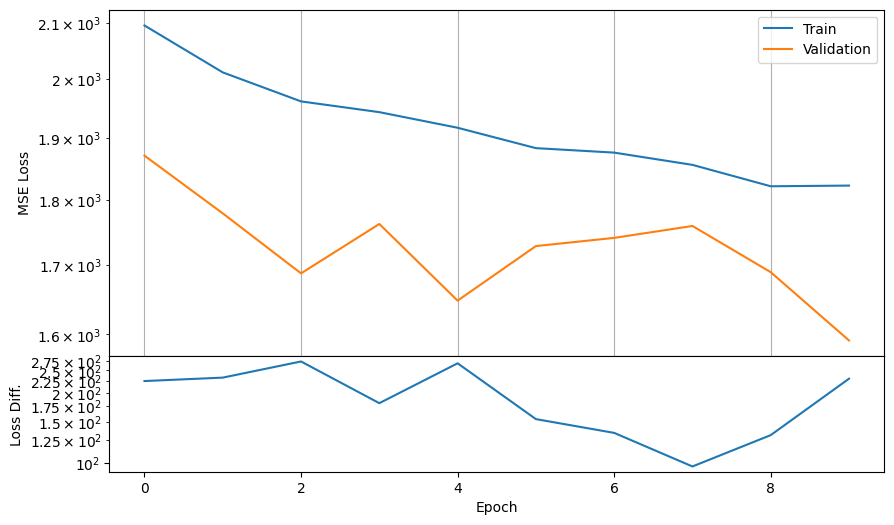

In [14]:
# Loss curves
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3, 1]}, figsize=(10, 6))
ax1.plot(np.arange(n_epochs), train_losses, label="Train")
ax1.plot(np.arange(n_epochs), eval_losses, label="Validation")
ax2.plot(np.arange(n_epochs), np.array(train_losses) - np.array(eval_losses), label="Train")
ax1.set_yscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax2.set_ylabel("Loss Diff.")
ax1.legend()
ax1.grid()
plt.subplots_adjust(hspace=0)
plt.savefig(plot_save_path+'/loss.pdf')

/var/folders/zb/dzv8y8kn1dl5qhcybvz_4nv00000gn/T/ipykernel_21865/1084479903.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  GP_res[NN_test_idx, :] = GP_test_output - NN_test_output
/var/folders/zb/dzv8y8kn1dl5qhcybvz_4nv00000gn/T/ipykernel_21865/1084479903.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  GP_res[NN_test_idx, :] = GP_test_output - NN_test_output
/var/folders/zb/dzv8y8kn1dl5qhcybvz_4nv00000gn/T/ipykernel_21865/1084479903.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  GP_res[NN_test_idx, :] = GP_test_output - NN_test_output


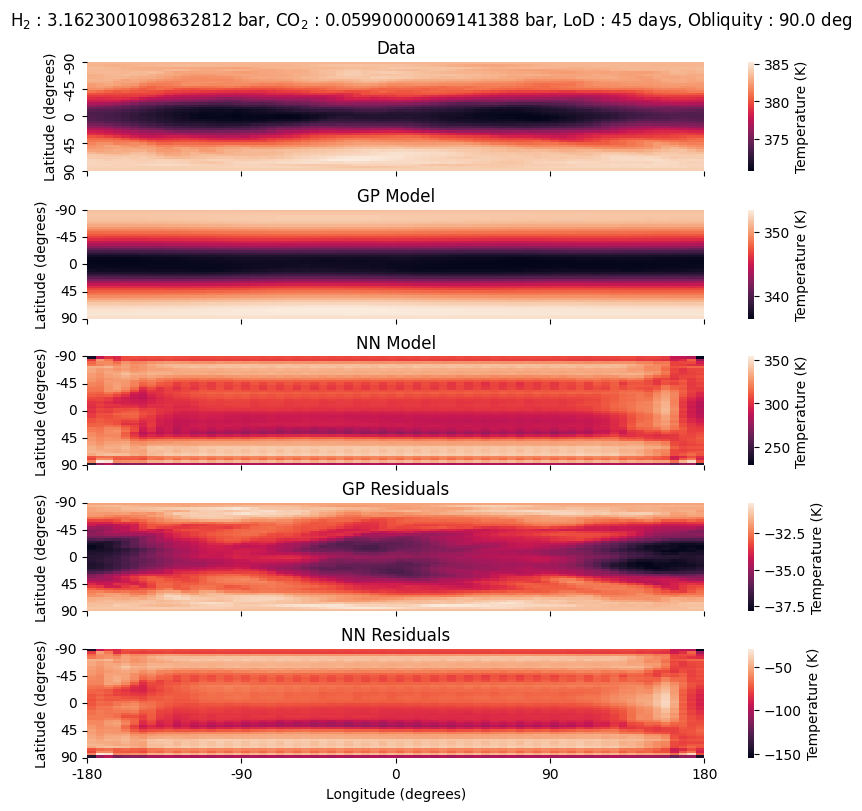

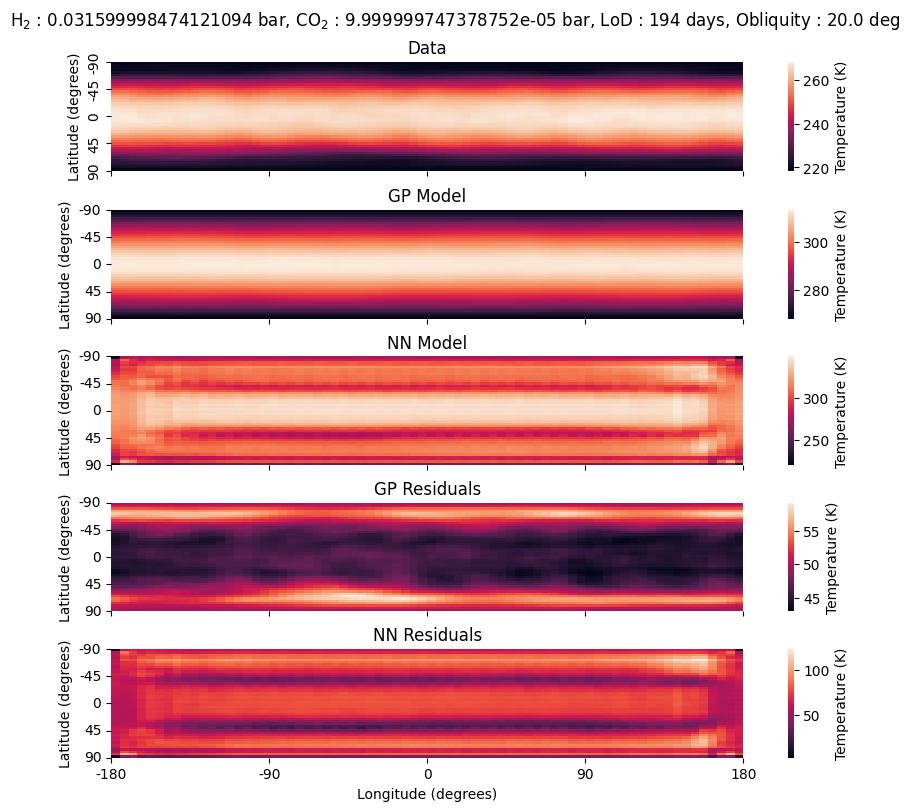

In [15]:
#Comparing GP predicted ST maps vs NN predicted ST maps vs true ST maps with residuals
substep = 1000

#Converting tensors to numpy arrays if this isn't already done
if (type(NN_test_outputs) != np.ndarray):
    NN_test_outputs = NN_test_outputs.numpy()

GP_res = np.zeros(NN_test_outputs.shape, dtype=float)
NN_res = np.zeros(NN_test_outputs.shape, dtype=float)

for NN_test_idx, (NN_test_input, GP_test_output, NN_test_output) in enumerate(zip(NN_test_og_inputs, NN_test_inputs, NN_test_outputs)):

    #Retrieve prediction
    NN_pred_output = model(GP_test_output.reshape(1, 1, 46, 72)).detach().numpy().reshape(3312)

    #Convert to numpy
    NN_test_input = NN_test_input.numpy()

    #Storing residuals 
    GP_res[NN_test_idx, :] = GP_test_output - NN_test_output
    NN_res[NN_test_idx, :] = NN_pred_output - NN_test_output

    #Plotting
    if (NN_test_idx % substep == 0):

        #Convert shape
        plot_test_output = NN_test_output.reshape((46, 72))
        plot_NN_test_output = NN_pred_output.reshape((46, 72))
        plot_GP_test_output = GP_test_output.reshape((46, 72))
        plot_res_GP = GP_res[NN_test_idx, :].reshape((46, 72))
        plot_res_NN = NN_res[NN_test_idx, :].reshape((46, 72))
        
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 8), sharex=True, layout='constrained')        
        # Compute global vmin/vmax across all datasets
        vmin = np.min(NN_test_output)
        vmax = np.max(NN_test_output)
        # Plot heatmaps
        ax1.set_title('Data')
        hm1 = sns.heatmap(plot_test_output, ax=ax1)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm1.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        ax2.set_title('GP Model')
        hm2 = sns.heatmap(plot_GP_test_output, ax=ax2)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm2.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        ax3.set_title('NN Model')
        hm3 = sns.heatmap(plot_NN_test_output, ax=ax3)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm3.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        ax4.set_title('GP Residuals')
        hm4 = sns.heatmap(plot_res_GP, ax=ax4)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm4.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        ax5.set_title('NN Residuals')
        hm5 = sns.heatmap(plot_res_NN, ax=ax5)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm5.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        # Shared colorbar (use the last heatmap's mappable)
        # cbar = fig.colorbar(hm3.get_children()[0], ax=[ax1, ax2, ax3], location='right')
        # cbar.set_label("Temperature")
        # Fix longitude ticks
        ax5.set_xticks(np.linspace(0, 72, 5))
        ax5.set_xticklabels(np.linspace(-180, 180, 5).astype(int))
        ax5.set_xlabel('Longitude (degrees)')
        # Fix latitude ticks
        for ax in [ax1, ax2, ax3, ax4, ax5]:
            ax.set_yticks(np.linspace(0, 46, 5))
            ax.set_yticklabels(np.linspace(-90, 90, 5).astype(int))
            ax.set_ylabel('Latitude (degrees)')
        plt.suptitle(rf'H$_2$ : {NN_test_input[0]} bar, CO$_2$ : {NN_test_input[1]} bar, LoD : {NN_test_input[2]:.0f} days, Obliquity : {NN_test_input[3]} deg')

        plt.savefig(plot_save_path+f'/pred_vs_actual_n.{NN_test_idx}.pdf')
    